### 1、添加数据集

<ipython-input-2-5f0a115702ab>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  minist_train_X = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
<ipython-input-2-5f0a115702ab>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  minist_train_Y = loaded[8:].reshape(60000).astype(np.float)
<ipython-input-2-5f0a115702ab>:17: Deprecati

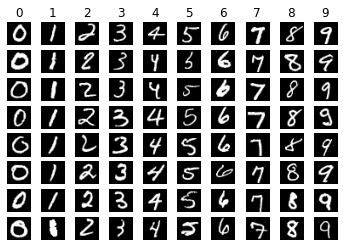

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_data(path):
    # load all MNIST data
    fd = open(os.path.join(path, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    minist_train_X = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    minist_train_Y = loaded[8:].reshape(60000).astype(np.float)
    fd = open(os.path.join(path, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    minist_test_X = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    minist_test_Y = loaded[8:].reshape(10000).astype(np.float)
   
    #visualize data
    sample_num = 8
    num_classes = 10
    for y in range(num_classes):
        idxs = np.flatnonzero(minist_train_Y == y)
        idxs = np.random.choice(idxs, sample_num, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(sample_num, num_classes, plt_idx)
            plt.imshow(minist_train_X[idx, :, :, :].reshape((28,28)),cmap=plt.cm.gray)
            plt.axis('off')
            if i == 0:
                plt.title(y)
    plt.show()

    # reshape into rows and normalize
    minist_train_X = minist_train_X.reshape((minist_train_X.shape[0]),-1)
    minist_test_X = minist_test_X.reshape((minist_test_X.shape[0]),-1)
    mean_image = np.mean(minist_train_X, axis = 0)
    minist_train_X = minist_train_X - mean_image
    minist_test_X = minist_test_X - mean_image

    # add a bias column into X
    minist_train_X = np.hstack([minist_train_X, np.ones((minist_train_X.shape[0], 1))])
    minist_test_X = np.hstack([minist_test_X, np.ones((minist_test_X.shape[0], 1))])
    minist_train_Y = minist_train_Y.astype(np.int32)
    minist_test_Y = minist_test_Y.astype(np.int32)

    return minist_train_X, minist_train_Y, minist_test_X, minist_test_Y

train_X_all, train_Y_all, test_X_all, test_Y_all = load_data('./dataset')





        




### 2、线性回归模型

In [3]:
from scipy.special import softmax
class LinearRegression_naive(object):
    def __init__(self, feat_dim, num_classes):
        self.W = 0.001 * np.random.randn(feat_dim, num_classes)
        self.M = np.zeros((785,1))
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, reg_type='L2', show_detail=True, with_op=False, op_param=5, num_iters=1000,
              batch_size=128):
        num_train = X.shape[0]
        loss_history = []
        if show_detail:
            print("train begin")
        for i in range(num_iters):
            batch_indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            if reg_type == 'L1':
                loss, grad = self.l1_loss(X_batch, Y_batch, reg)
            elif reg_type == 'L2':
                loss, grad = self.l2_loss(X_batch, Y_batch, reg)
            else :
                loss, grad = self.calc(X_batch, Y_batch)

            loss_history.append(loss)

            if with_op:
                self.W = self.W - learning_rate * (grad - np.dot(np.dot(self.M, self.M.T), grad))
            else:
                self.W = self.W - learning_rate * grad
       
            if show_detail and i % 100 == 0:
                print("In iteration {}/{} , the loss is {}".format(i, num_iters, loss))
            
        if with_op:
            for i in range(op_param):
                batch_indices = np.random.choice(num_train, batch_size, replace = True)
                X_batch = X[batch_indices]
                mean_X = np.mean(X_batch, axis=0).T
                mean_X = mean_X - np.dot(np.dot(self.M, self.M.T), mean_X)
                mean_X = mean_X / np.linalg.norm(mean_X)
                mean_X = mean_X.reshape(-1, 1)
                self.M = np.append(self.M, mean_X, axis=1)

        return loss_history

    def calc(self, X, Y):
        num_train, feat_dim = X.shape
        class_dim = self.W.shape[1]
        loss = 0
        grad = np.zeros([class_dim, feat_dim])
        for i in range(num_train):
            soft = softmax(np.dot(X[i], self.W))
            loss += -np.log(soft[Y[i]])
            for j in range(class_dim):
                prob = soft[j]
                if j == Y[i]:
                    prob -= 1
                grad[j] += X[i] * prob
        grad = grad.T
        return loss / X.shape[0], grad / X.shape[0]

    def l1_loss(self,X, Y, reg):
        loss, grad = self.calc(X,Y)
        loss = loss + reg * np.linalg.norm(self.W, ord = 1)
        grad = grad + reg * np.sign(self.W)
    
        return loss, grad
            
    
    def l2_loss(self, X, Y, reg):
        loss, grad = self.calc(X, Y)
        loss = loss + reg * np.power(np.linalg.norm(self.W, ord = 2), 2)
        grad = grad + 2 * reg * self.W
        
        return loss, grad

    def predict(self, X):
        Y_pred = None
        Y_pred = np.argmax(softmax(np.dot(X, self.W)), axis = 1)
    
        return Y_pred
        
def divide(a, b):
    return a / b

#### 训练模型

In [156]:
# initial the model
lr_param = 1e-6
reg_param = 0.01
model = LinearRegression_naive(785, 10)

# Continual Learning
num_classes = 10
for i in range(num_classes):
    # take the data
    train_idx = (train_Y_all == i)
    test_idx = (test_Y_all == i)
    train_X = train_X_all[train_idx]
    train_Y = train_Y_all[train_idx]
    test_X = test_X_all[test_idx]
    test_Y = test_Y_all[test_idx]

    #train the model
    loss_history = model.train(train_X, train_Y, lr_param, reg_param, 'None', True, True, 15)
    pred = model.predict(test_X)
    acc = np.mean(pred == test_Y)
    print("The Accuracy is {}\n".format(acc))

total_pred = model.predict(test_X_all)
total_acc = np.mean(total_pred == test_Y_all)
print("The final Accuracy is {}\n".format(total_acc))
for i in range(num_classes):
    # take the data
    test_idx = (test_Y_all == i)
    test_X = test_X_all[test_idx]
    test_Y = test_Y_all[test_idx]

    #predict
    pred = model.predict(test_X)
    acc = np.mean(pred == test_Y)
    print("The Accuracy is {}\n".format(acc))




train begin
In iteration 0/1000 , the loss is 3.031514927498789
In iteration 100/1000 , the loss is 0.12433541208020688
In iteration 200/1000 , the loss is 0.07729410450191558
In iteration 300/1000 , the loss is 0.07542891733206557
In iteration 400/1000 , the loss is 0.033551674444998014
In iteration 500/1000 , the loss is 0.01365986458105197
In iteration 600/1000 , the loss is 0.07289038903318497
In iteration 700/1000 , the loss is 0.0016970802605476903
In iteration 800/1000 , the loss is 0.006734236337502891
In iteration 900/1000 , the loss is 0.003944029341399494
The Accuracy is 0.996938775510204

train begin
In iteration 0/1000 , the loss is 3.342206289914651
In iteration 100/1000 , the loss is 0.059365971714900205
In iteration 200/1000 , the loss is 0.017535220212838633
In iteration 300/1000 , the loss is 0.07659958737494803
In iteration 400/1000 , the loss is 0.02488228106942057
In iteration 500/1000 , the loss is 0.029967686477245424
In iteration 600/1000 , the loss is 0.0191919

### 3、两层神经网络模型

In [4]:
class Layer():
    def __init__(self):
        pass
    
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, node_grad):
        raise NotImplementedError
    
    def update(self, learning_rate):
        raise NotImplementedError
    
    def update_M(self):
        raise NotImplementedError

In [5]:
# Relu激活函数实现
class Relu():        
    def forward(self, x):
        self.x = x
        self.sign = x > 0
        self.y = self.x * self.sign
        return self.y
        
    def backward(self, node_grad):
        return node_grad * self.sign

    def update(self, learning_rate):
        pass
    
    def update_M(self):
        pass

In [6]:
# Sigmoid激活函数实现
class Sigmoid(Layer):    
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, node_grad):
        return node_grad * (self.y * (1-self.y))
    
    def update(self, learning_rate):
        pass
    def update_M(self):
        pass

In [7]:
# Softmax激活函数实现
class Softmax_Cross_Entropy():
    def forward(self, x):
        self.S = softmax(x, axis=1)
        return self.S
    
    # 根据Softmax与交叉熵的梯度公式实现反向传播函数
    def backward(self, label):
        grad = self.S
        for i in range(label.shape[0]):
            grad[i][label[i]]-=1
        return grad
    
    def update(self, learning_rate):
        pass
    def update_M(self):
        pass

In [8]:
class Linear(Layer):    
    def __init__(self, size_in, size_out, with_op=False):
        self.size_in = size_in + 1
        self.size_out = size_out
        self.W = self.initialize_weight()
        self.with_op = with_op
        self.M = np.zeros((self.size_in, 1))
    
    def initialize_weight(self):
        epsilon = np.sqrt(2.0 / (self.size_in + self.size_out))
        return epsilon * (np.random.rand(self.size_in, self.size_out) * 2 - 1)
        
    def forward(self, x):
        self.x = np.append(x, np.ones((x.shape[0], 1)), axis=1)
        self.y = np.dot(self.x, self.W)
        return self.y
    
    def backward(self, node_grad):
        self.G_w = np.dot(self.x.T, node_grad) / node_grad.shape[0]
        if self.with_op:
            self.G_w = self.G_w - np.dot(np.dot(self.M, self.M.T), self.G_w)
        
        return np.delete(np.dot(node_grad, self.W.T), -1, axis=1)
    
    # 更新参数以完成梯度下降
    def update(self, learning_rate):
        self.W -= learning_rate * self.G_w
    
    def update_M(self):
        mean_x = np.mean(self.x, axis=0).T
        mean_x = mean_x - np.dot(np.dot(self.M, self.M.T), mean_x)
        mean_x = (mean_x / np.linalg.norm(mean_x)).reshape(-1, 1)
        self.M = np.append(self.M, mean_x, axis=1)
        
        

In [9]:
class Neuron_network():    
    def __init__(self, layer_size, activation="sigmoid", learning_rate=1):
        assert len(layer_size) >= 2
        self.layer_size = layer_size
        if activation == "sigmoid":
            self.activation = Sigmoid
        elif activation == "relu":
            self.activation = Relu
        else:
            raise Exception("activation not implemented")
        self.learning_rate = learning_rate
        self.build_model()
        
    def build_model(self):
        self.layers = []
        
        size_in = self.layer_size[0]
        for hu in self.layer_size[1:-1]:
            self.layers.append(Linear(size_in, hu, True))
            self.layers.append(self.activation())
            size_in = hu
            
        # 最后一层将会使用softmax+cross_entropy
        self.layers.append(Linear(size_in, self.layer_size[-1], True))
        self.layers.append(Softmax_Cross_Entropy())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, label):
        node_grad = label
        for layer in reversed(self.layers):
            node_grad = layer.backward(node_grad)
            
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
            
    def train(self, x, label):
        y = self.forward(x)# 前向计算结果
        self.backward(label)# 反向计算梯度
        self.update(self.learning_rate) # 根据梯度更新参数
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x, axis=1)
    
    def loss(self, x, label):
        y = self.forward(x)
        loss = 0
        for i in range(y.shape[0]):
            loss += -np.log(y[i][label[i]])
        loss = loss / y.shape[0]
        return loss
    
    def update_M(self, x):
        for layer in self.layers:
            x = layer.forward(x)
            layer.update_M()
    
        

#### 训练神经网络模型

<ipython-input-9-976f14321ba3>:55: RuntimeWarning: divide by zero encountered in log
  loss += -np.log(y[i][label[i]])
No handles with labels found to put in legend.


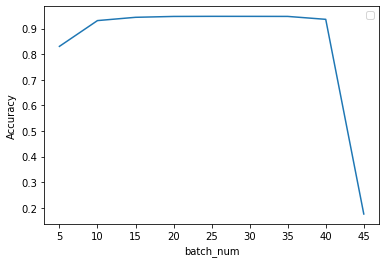

In [13]:

import matplotlib.pyplot as plt
np.random.seed(1007)
Neuron_model = Neuron_network([784, 800, 10], learning_rate=0.001, activation="relu")
epoch = 200
batch_size = 128
op_param = 40

#delte the bias column (we will add the bias column in the layer)
train_X_all_n = np.delete(train_X_all, -1, axis=1)
test_X_all_n = np.delete(test_X_all, -1, axis=1)
op_param_list = [5,10,15,20,25,30,35,40,45]
totalacc_list = np.zeros(len(op_param_list))
for k in range(len(op_param_list)):
    x = range(10)
    acclist_jt = np.zeros(10)
    acclist_at = np.zeros(10)
    for i in range(10):

        # take the data
        train_idx = (train_Y_all == i)
        test_idx = (test_Y_all == i)
        train_X = train_X_all_n[train_idx]
        train_Y = train_Y_all[train_idx]
        test_X = test_X_all_n[test_idx]
        test_Y = test_Y_all[test_idx]

        #train the model
        for j in range(epoch):
            batch_indices = np.random.choice(train_X.shape[0], batch_size, replace=True)
            X_batch = train_X[batch_indices]
            Y_batch = train_Y[batch_indices]
            Neuron_model.train(X_batch, Y_batch)

            if j % 10 == 0:
                loss = Neuron_model.loss(X_batch, Y_batch)
                #print("In iteration {}/{} , the loss is {}".format(j, epoch, loss))
        pred = Neuron_model.predict(test_X)
        acc = np.mean(pred == test_Y)
        acclist_jt[i] = acc
        #print("The Accuracy is {}\n".format(acc))

        for j in range(op_param_list[k]):
            batch_indices = np.random.choice(train_X.shape[0], batch_size, replace=True)
            X_batch = train_X[batch_indices]
            Neuron_model.update_M(X_batch)

    for i in range(10):
        test_idx = (test_Y_all == i)
        test_X = test_X_all_n[test_idx]
        test_Y = test_Y_all[test_idx]
        pred = Neuron_model.predict(test_X)
        acc = np.mean(pred == test_Y)
        acclist_at[i] = acc
    #plt.plot(x, acclist_jt, label = 'batch_num='+str(op_param_list[k]))
    #plt.plot(x, acclist_at, label = 'final, batch_num='+str(op_param_list[k]))
    totalpred = Neuron_model.predict(test_X_all_n)
    totalacc = np.mean(totalpred == test_Y_all)
    totalacc_list[k]=totalacc
#totalpred = Neuron_model.predict(test_X_all_n)
#totalacc = np.mean(totalpred == test_Y_all)
#print("The Final Accuracy is {}\n".format(totalacc))
x = range(0,len(op_param_list), 1)
plt.plot(x, totalacc_list)
plt.xticks(x, op_param_list)
plt.legend()
plt.xlabel('batch_num')
plt.ylabel('Accuracy')
plt.show()




In [94]:
model_test = Neuron_network([785, 800, 10], learning_rate=0.001, activation="relu")
epoch_test = 1000
for i in range(epoch_test):
    batch_indices = np.random.choice(train_X_all_n.shape[0], batch_size, replace=True)
    X_batch = train_X_all_n[batch_indices]
    Y_batch = train_Y_all[batch_indices]
    model_test.train(X_batch, Y_batch)

    if i % 100 == 0:
        loss = Neuron_model.loss(X_batch, Y_batch)
        print("In iteration {}/{} , the loss is {}".format(i, epoch_test, loss))
pred_test = model_test.predict(test_X_all_n)
acc_test = np.mean(pred_test == test_Y_all)
print("The test Accuracy is {}\n".format(acc_test))
  

In iteration 0/1000 , the loss is 0.09459375705738532
In iteration 100/1000 , the loss is 0.5801502769572082
In iteration 200/1000 , the loss is 0.45771813520522053
In iteration 300/1000 , the loss is 0.03711460255181606
In iteration 400/1000 , the loss is 0.08204684283709203
In iteration 500/1000 , the loss is 0.14655579040938627
In iteration 600/1000 , the loss is 0.4926248859589343
In iteration 700/1000 , the loss is 0.05289433831608581
In iteration 800/1000 , the loss is 0.314714597474164
In iteration 900/1000 , the loss is 0.11859089357967087
The test Accuracy is 0.9532

